## ReTap - UPDRS-Tapping Assessment - Automated 10-sec block selection

This notebooks finds, plots, and stores 10-sec-tapping blocks out of raw accelerometer data.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime as dt
import h5py
from dataclasses import  dataclass, field
from itertools import compress
from typing import Any

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)


## developed with:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

## Currently (Mac) since 31.08.22
# Python sys 3.9.12 (main, Jun  1 2022, 06:36:29) 
# [Clang 12.0.0 ]
# pandas 1.4.3
# numpy 1.21.5
# sci-py 1.7.3
# sci-kit learn 1.1.1

## Currently (WIN)
# Python sys 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
# pandas 1.4.4
# numpy 1.23.3
# sci-py 1.9.1
# sci-kit learn 1.1.2

Python sys 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-py 1.9.1
sci-kit learn 1.1.2


In [3]:
import run_finding_10sec_blocks as run_blocks

In [4]:
# own data preprocessing functions
import tap_load_data.updrsTapping_import as tap_import
import tap_load_data.tapping_preprocess as tap_preproc
import tap_load_data.tapping_find_blocks as find_blocks
import tap_load_data.tapping_impact_finder as tap_impact
import tap_load_data.tapping_time_detect as tap_times

import tapping_run as tap_run

# ft extraction
import tap_extract_fts.tapping_featureset as tap_fts_set
import tap_extract_fts.tapping_extract_features as tap_ft_extr
import tap_extract_fts.tapping_feat_calc as ft_calc

# own data exploration functions
import tap_extract_fts.tapping_feat_boxplots as fts_boxplot

# own helper functions
from retap_utils import utils_dataManagement, tmsi_poly5reader, utils_preprocessing

In [8]:
data_path = utils_dataManagement.find_stored_data_path('retapdata')
f = 'acc_side_test_right_moving-20221104T130052.DATA.Poly5'

test = tmsi_poly5reader.Poly5Reader(
    os.path.join(data_path, f)
)

Reading file  c:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\ReTap\data\acc_side_test_right_moving-20221104T130052.DATA.Poly5
	 Number of samples:  80352 
	 Number of channels:  11 
	 Sample rate: 4000 Hz
Done reading data.


['X', 'Y', 'Z', 'X', 'Y', 'Z', 'X-AXIS', 'Y-AXIS', 'Z-AXIS', 'STATUS', 'Counter 2power24']


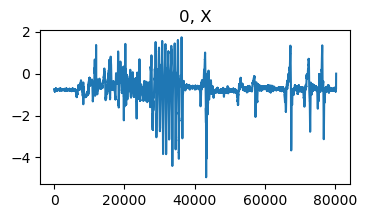

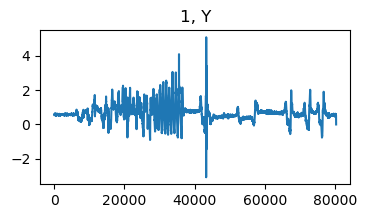

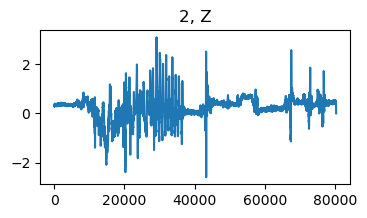

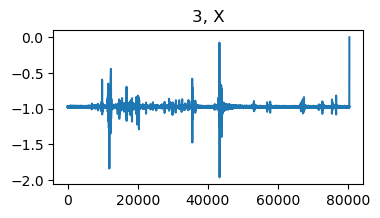

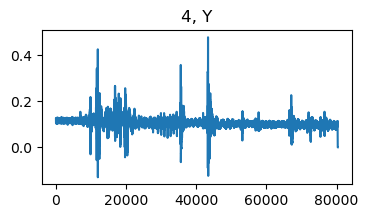

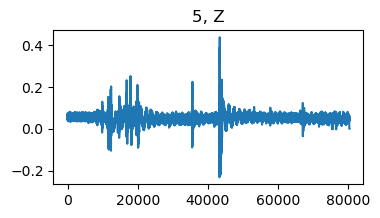

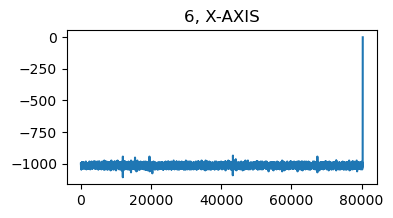

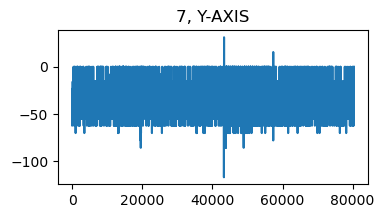

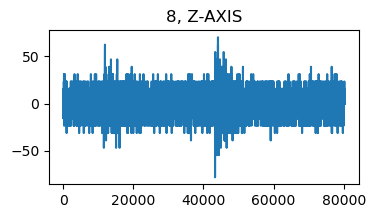

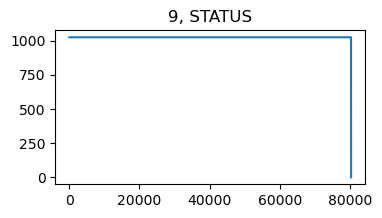

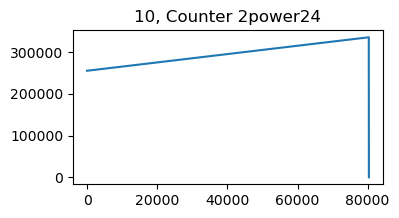

In [13]:
print(test.ch_names)

for i, key in enumerate(test.ch_names):

    # if np.logical_or(i==0, 'aux' in key.lower()):
    plt.figure(figsize=(4,2))
    plt.plot(test.samples[i, :].T)
    plt.title(f'{i}, {key}')
    plt.show()


In [11]:
importlib.reload(utils_dataManagement)
importlib.reload(utils_preprocessing)
importlib.reload(tmsi_poly5reader)
importlib.reload(run_blocks)
importlib.reload(find_blocks)
importlib.reload(tap_preproc)

uncut_path = utils_dataManagement.find_stored_data_path()
print(uncut_path)

data = run_blocks.rawAccData(
    sub='021',
    state='M0S1',  # 'MOnSOff'
    # joker_string='L',
    uncut_path=uncut_path
)

c:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\ReTap\data\BER\UNCUT
files selected: ['Sub021_12mfu_M0S1_Bstr_FT - 20220520T104608.DATA.Poly5']
Reading file  c:\Users\habetsj\OneDrive - Charité - Universitätsmedizin Berlin\ReTap\data\BER\UNCUT\Sub021_12mfu_M0S1_Bstr_FT - 20220520T104608.DATA.Poly5
	 Number of samples:  574697 
	 Number of channels:  38 
	 Sample rate: 2048 Hz
Done reading data.
selected channels: {'L_X': 28, 'L_Y': 29, 'L_Z': 30}
	out of ['ExG1', 'ExG2', 'ExG3', 'ExG4', 'ExG5', 'ExG6', 'ExG7', 'ExG8', 'ExG9', 'ExG10', 'ExG11', 'ExG12', 'ExG13', 'ExG14', 'ExG15', 'ExG16', 'Bip17', 'Bip18', 'Bip19', 'Bip20', 'Bip21', 'Bip22', 'Bip23', 'Bip24', 'Bip25', 'Bip26', 'Bip27', 'Bip28', 'Aux29', 'Aux30', 'Aux31', 'Empty', 'SaO2', 'Pleth', 'HRate', 'Status', 'Digi', 'Saw']
No right indices


ACT THRESH. 0.11459610614408358


deleted blocks: [4]
# 7 tapping blocks detected, lengths (in sec): [5.332, 12.276, 12.276, 12.152, 12.772, 11.036, 10.788]


# BLOCKS 3
plot

['ExG1', 'ExG2', 'ExG3', 'ExG4', 'ExG5', 'ExG6', 'ExG7', 'ExG8', 'ExG9', 'ExG10', 'ExG11', 'ExG12', 'ExG13', 'ExG14', 'ExG15', 'ExG16', 'Bip17', 'Bip18', 'Bip19', 'Bip20', 'Bip21', 'Bip22', 'Bip23', 'Bip24', 'Bip25', 'Bip26', 'Bip27', 'Bip28', 'Aux29', 'Aux30', 'Aux31', 'Empty', 'SaO2', 'Pleth', 'HRate', 'Status', 'Digi', 'Saw']


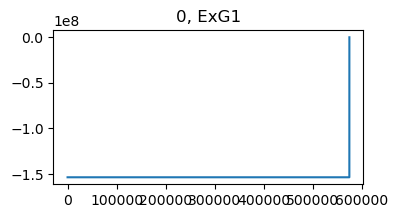

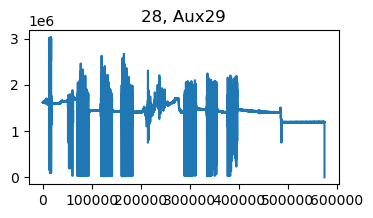

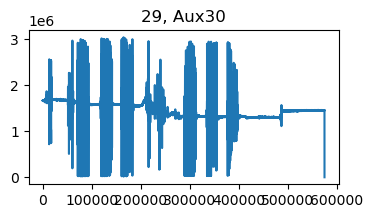

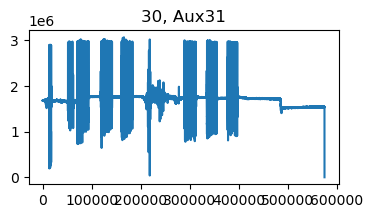

In [12]:
print(data.raw.ch_names)

for i, key in enumerate(data.raw.ch_names):

    if np.logical_or(i==0, 'aux' in key.lower()):
        plt.figure(figsize=(4,2))
        plt.plot(data.raw.samples[i, :].T)
        plt.title(f'{i}, {key}')
        plt.show()
